# Лабораторная работа 2

Вариант - 9

Датасеты - магазины

1. Цены на кофе	https://www.kaggle.com/datasets/mayankanand2701/starbucks-stock-price-dataset
2. Цены на акции	https://www.kaggle.com/datasets/nancyalaswad90/yamana-gold-inc-stock-price
3. Цены на золото	https://www.kaggle.com/datasets/sid321axn/gold-price-prediction-dataset


Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'x', 'y', 'z'],
      dtype='object')
Зашумленные столбцы: []
Смещение: id         0.000000
carat      1.116705
cut       -0.717161
color     -0.189454
clarity    0.551503
depth     -0.082187
table      0.796836
price      1.618476
x          0.378685
y          2.434233
z          1.522481
dtype: float64
Сильно смещенные столбцы: ['carat', 'price', 'y', 'z']
Данные 2022 года, возможна неактуальность
Выбросы в столбце 'carat':
12246    2.06
13002    2.14
13118    2.15
13757    2.22
13991    2.01
         ... 
27741    2.15
27742    2.04
27744    2.29
27746    2.07
27749    2.29
Name: carat, Length: 1889, dtype: float64

Выбросы в столбце 'cut':
Series([], Name: cut, dtype: int64)

Выбросы в столбце 'color':
Series([], Name: color, dtype: int64)

Выбросы в столбце 'clarity':
Series([], Name: clarity, dtype: int64)

Выбросы в столбце 'depth':
2        56.9
8        65.1
24       58.1
35       58.2
42      

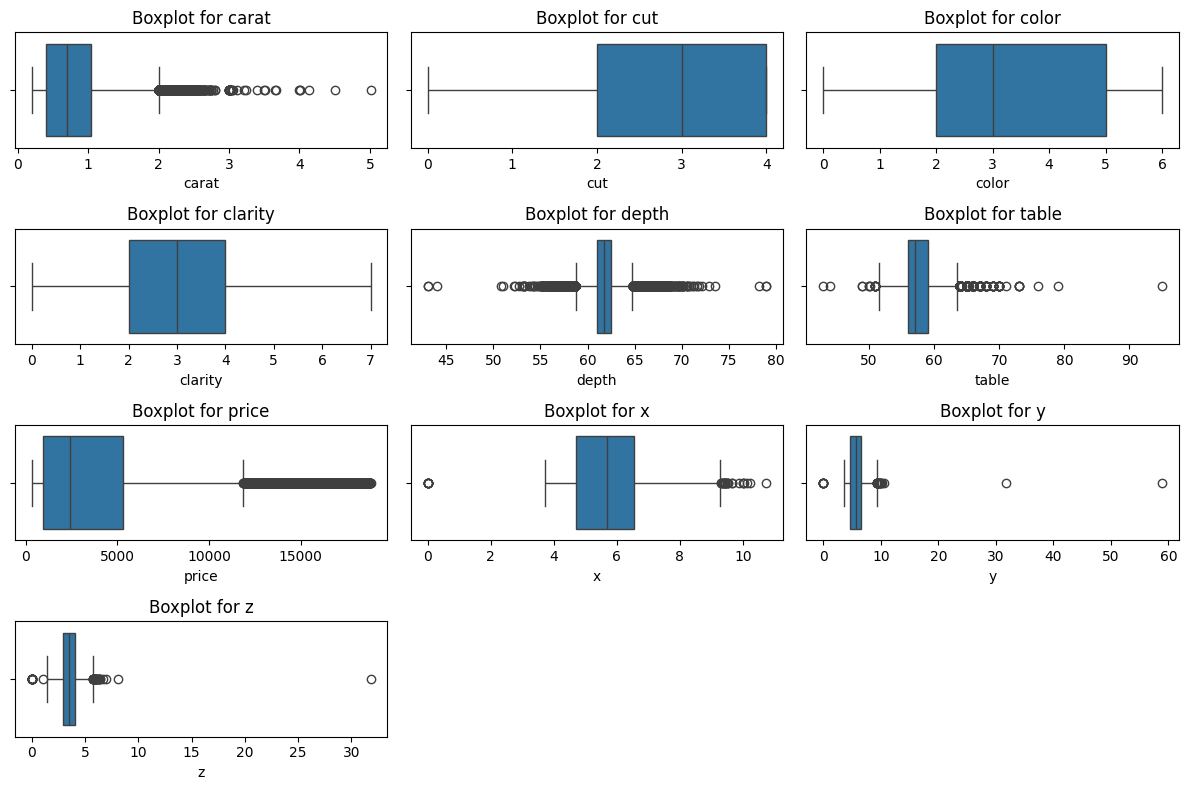

Просачивание данных: Высокая корреляция (0.92) между столбцами 'carat' и 'price'
Просачивание данных: Высокая корреляция (0.98) между столбцами 'carat' и 'x'
Просачивание данных: Высокая корреляция (0.95) между столбцами 'carat' и 'y'
Просачивание данных: Высокая корреляция (0.95) между столбцами 'carat' и 'z'
Просачивание данных: Высокая корреляция (0.92) между столбцами 'price' и 'carat'
Просачивание данных: Высокая корреляция (0.98) между столбцами 'x' и 'carat'
Просачивание данных: Высокая корреляция (0.97) между столбцами 'x' и 'y'
Просачивание данных: Высокая корреляция (0.97) между столбцами 'x' и 'z'
Просачивание данных: Высокая корреляция (0.95) между столбцами 'y' и 'carat'
Просачивание данных: Высокая корреляция (0.97) между столбцами 'y' и 'x'
Просачивание данных: Высокая корреляция (0.95) между столбцами 'y' и 'z'
Просачивание данных: Высокая корреляция (0.95) между столбцами 'z' и 'carat'
Просачивание данных: Высокая корреляция (0.97) между столбцами 'z' и 'x'
Просачивани

In [7]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/Diamonds.csv")
print(df.columns)

noisy_features = []
for col in df.columns:
  if df[col].isnull().sum() / len(df) > 0.1:  # Если более 10% пропусков
    noisy_features.append(col)
print(f"Зашумленные столбцы: {noisy_features}")

cut_mapping = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
df['cut'] = df['cut'].map(cut_mapping)

color_mapping = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6} 
df['color'] = df['color'].map(color_mapping)

clarity_mapping = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7} 
df['clarity'] = df['clarity'].map(clarity_mapping)

skewness = df.skew()
print(f"Смещение: {skewness}")

skewed_features = skewness[abs(skewness) > 1].index.tolist()
print(f"Сильно смещенные столбцы: {skewed_features}")

for col in df.select_dtypes(include=['number']).columns:
    if col == 'id':
        continue
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[col][(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Выбросы в столбце '{col}':\n{outliers}\n")

numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols = [col for col in numeric_cols if col != 'id']

plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i) 
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

if len(df.columns) >= 2:
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                correlation = df[col1].corr(df[col2])
                if abs(correlation) > 0.9:
                    print(f"Просачивание данных: Высокая корреляция ({correlation:.2f}) между столбцами '{col1}' и '{col2}'")

df['log_carat'] = np.log(df['carat'] + 1)

df['cut'] = df['cut'].fillna('unknown')

df['carat'] = df['carat'].fillna(df['carat'].mean())

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input 
    y = df_input[
        [stratify_colname]
    ]  

    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

data = df[["carat", "price", "cut"]].copy()

df_train, df_val, df_test = split_stratified_into_train_val_test(
    data, stratify_colname="cut", frac_train=0.60, frac_val=0.20, frac_test=0.20
)
   
print(df_train.columns) 
   
print("Обучающая выборка: ", df_train.shape)
print(df_train.carat.value_counts()) 

print("Контрольная выборка: ", df_val.shape)
print(df_val.carat.value_counts())

print("Тестовая выборка: ", df_test.shape)
print(df_test.carat.value_counts())

ada = ADASYN()

X_resampled, y_resampled = ada.fit_resample(df_train, df_train["cut"])
df_train_adasyn = pd.DataFrame(X_resampled)

print("Обучающая выборка после oversampling: ", df_train_adasyn.shape)
print(df_train_adasyn.carat.value_counts())


**Датасет 1. Цены бриллиантов**
1. **carat**: Вес бриллианта в каратах
2. **cut**: Качество огранки.
3. **color**: Цвет бриллианта
4. **clarity**: Чистота бриллианта
5. **depth**: Процент глубины бриллианта
6. **table**: Процент ширины бриллианта
7. **price**: Цена бриллианта в долларах США
8. **x**: Длина бриллианта в миллиметрах
9. **y**: Ширина бриллианта в миллиметрах
10. **z**: Глубина бриллианта в миллиметрах

**Объект наблюдения**: Каждый объект представляет собой отдельный бриллиант.\
**Связи между объектами**: Внутри одного объекта есть взаимосвязь между характеристиками и его ценой. Например, вес, цвет, чистота и огранка могут влиять на цену.\
**Бизнес-цель**: Оптимизация продаж бриллиантов, оценка цен в зависимости от характеристик.\
**Эффект для бизнеса**: Более точная оценка стоимости бриллиантов может помочь ювелирам предлагать конкурентоспособные цены и максимизировать прибыль.\
**Техническая цель**: Построение модели машинного обучения для прогнозирования цены бриллианта на основе его характеристик.\
* **Вход**: Характеристики бриллианта (вес, огранка, цвет, чистота, размеры).\
* **Целевой признак**: Цена бриллианта. 

**Информативность**: Высокая. Набор данных содержит важные характеристики бриллиантов, которые влияют на их цену: карат, огранка, цвет, чистота, размеры.\
**Степень покрытия**: Высокая. В наборе данных представлено 53 940 бриллиантов, что является достаточно большим объемом для анализа. \
**Соответствие реальным данным**: Высокая. Характеристики бриллиантов в наборе данных соответствуют реальным характеристикам бриллиантов, определяемым геммологами. \
**Согласованность меток**: Высокая. В данном наборе данных нет проблем с несогласованностью меток, так как все данные соответствуют описанию в заголовках столбцов. 

**Датасет 2. Цены акций Starbucks**
1. **Date**: Дата торгов
2. **Open**: Цена открытия торгов
3. **High**: Максимальная цена акции за день
4. **Low**: Минимальная цена акции за день
5. **Close**: Цена закрытия торгов в данный день
6. **Adj Close**: Скоректированная цена закрытия.
7. **Volume**: Объем торгов акциями в данный день.

**Объект наблюдения**: Объектом наблюдения является торговый день на рынке акций компании Starbucks.\
**Связи между объектами**: Временная связь между днями торгов. Важна динамика изменений цен и объемов торгов в зависимости от времени.\
**Бизнес-цель**: Прогнозирование цен акций для управления портфелем акций.\
**Эффект для бизнеса**: Прогнозирование позволит трейдерам принимать более информированные решения, оптимизировать инвестиции и минимизировать риски.\
**Техническая цель**: Прогнозирование цены закрытия акций на основе временных рядов.\
* **Вход**: Временные ряды с историческими данными по ценам открытия, закрытия, объёмам.\
* **Целевой признак**: Цена закрытия на следующий день.

**Датасет 3. Цены на золото**
1. **Date**: Дата
2. **Open**: Цена открытия торгов
3. **High**: Максимальная цена за день
4. **Low**: Минимальная цена за день
5. **Close**: Цена закрытия торгов
6. **Adjusted Close**: Скоректированная цена закрытия
7. **Volume**: Объем торгов за день

**Дополнительные столбцы (факторы, влияющие на цену золота):**

8. **SP_open**, **SP_high**, **SP_low**, **SP_close**, **SP_Ajclose**, **SP_volume**: Данные индекса S&P 500.
9. **DJ_open**, **DJ_high**, **DJ_low**, **DJ_close**, **DJ_Ajclose**, **DJ_volume**: Данные индекса Dow Jones.
10. **EG_open**, **EG_high**, **EG_low**, **EG_close**, **EG_Ajclose**, **EG_volume**: Данные компании Eldorado Gold Corporation (EGO).
11. **EU_Price**, **EU_open**, **EU_high**, **EU_low**, **EU_Trend**: Курс валютной пары EUR/USD.
12. **OF_Price**, **OF_Open**, **OF_High**, **OF_Low**, **OF_Volume**, **OF_Trend**: Цена фьючерсов на нефть Brent.
13. **OS_Price**, **OS_Open**, **OS_High**, **OS_Low**, **OS_Trend**: Цена нефти WTI.
14. **SF_Price**, **SF_Open**, **SF_High**, **SF_Low**, **SF_Volume, SF_Trend**: Цена фьючерсов на серебро.
15. **USB_Price**, **USB_Open**, **USB_High**, **USB_Low**, **USB_Trend**: Ставка по облигациям США.
16. **PLT_Price**, **PLT_Open**, **PLT_High**, **PLT_Low**, **PLT_Trend**: Цена платины.
17. **PLD_Price**, **PLD_Open**, **PLD_High**, **PLD_Low**, **PLD_Trend**: Цена палладия.
18. **RHO_PRICE**: Цена родия.
19. **USDI_Price**, **USDI_Open**, **USDI_High**, **USDI_Low**, **USDI_Volume**, **USDI_Trend**: Индекс доллара США.
20. **GDX_Open**, **GDX_High**, **GDX_Low**, **GDX_Close**, **GDX_Adj Close**, **GDX_Volume**: Данные ETF на золотые шахты.
21. **USO_Open**, **USO_High**, **USO_Low**, **USO_Close**, **USO_Adj Close**, **USO_Volume**: Данные ETF на нефть USO.

**Объект наблюдения**: Объектом наблюдения является торговый день для цены золота с дополнительными факторами влияния.\
**Связи между объектами**: Взаимосвязь между движением цен на золото и другими экономическими показателями и активами (например, нефть, фондовые индексы). Золото часто коррелирует с другими активами в периоды нестабильности.\
**Бизнес-цель**: Управление инвестициями в золото и связанные активы (нефть, индексы).\
**Эффект для бизнеса**: Правильное прогнозирование цен на золото и связанных активов может помочь инвесторам защитить капитал.\
**Техническая цель**: Построение модели для анализа взаимосвязи между ценами на золото и дополнительными факторами (нефть, фондовые индексы, валютные курсы).
* **Вход**: Данные по ценам на золото и дополнительным факторам (нефть, индексы, валюты).\
* **Целевой признак**: Цена закрытия золота.